# HW1 - Q4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.interpolate import BSpline
from scipy.ndimage import gaussian_filter


In [2]:
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    '''Return B-Spline basis. Python equivalent to bs in R or the spmak/spval combination in MATLAB.
    This function acts like the R command bs(x,knots=knots,degree=degree, intercept=False)
    Arguments:
        x: Points to evaluate spline on, sorted increasing
        knots: Spline knots, sorted increasing
        degree: Spline degree. 
    Returns:
        B: Array of shape (x.shape[0], len(knots)+degree+1). 
    Note that a spline has len(knots)+degree coefficients. However, because the intercept is missing 
    you will need to remove the last 2 columns. It's being kept this way to retain compatibility with
    both the matlab spmak way and how R's bs works.

    If K = length(knots) (includes boundary knots)
    Mapping this to R's bs: (Props to Nate Bartlett )
    bs(x,knots,degree,intercept=T)[,2:K+degree] is same as BSplineBasis(x,knots,degree)[:,:-2]
    BF = bs(x,knots,degree,intercept=F) drops the first column so BF[,1:K+degree] == BSplineBasis(x,knots,degree)[:,:-2]
    '''
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

In [3]:
# Import data, split into test/train
data = pd.read_csv('Question4.csv', header=None)
# rows = 60 samples, columns = olive oil features

X = data.iloc[:,:-1]
y = data.iloc[:,-1]
y_train = data.iloc[0:30,-1]
y_test = data.iloc[30:60,-1]

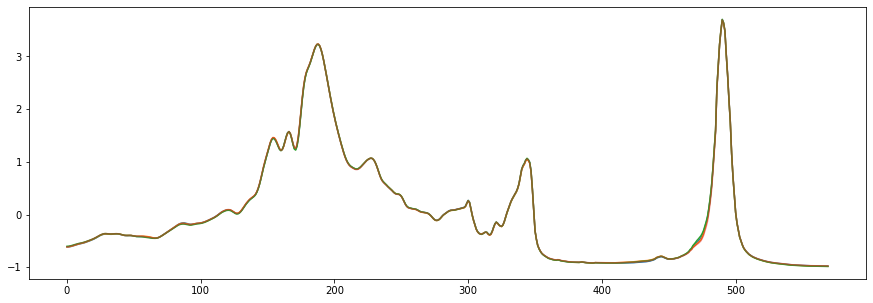

In [4]:
# Recreate plot
mean_1 = data[data[570]==1].iloc[:,:-1].mean(axis=0)
mean_2 = data[data[570]==2].iloc[:,:-1].mean(axis=0)
mean_3 = data[data[570]==3].iloc[:,:-1].mean(axis=0)
mean_4 = data[data[570]==4].iloc[:,:-1].mean(axis=0)

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)

plt.plot(mean_1, color = 'tab:blue')
plt.plot(mean_2, color = 'tab:orange')
plt.plot(mean_3, color = 'tab:green')
plt.plot(mean_4, color = 'tab:red', alpha=0.5)

Text(0.5, 1.0, 'Class 4')

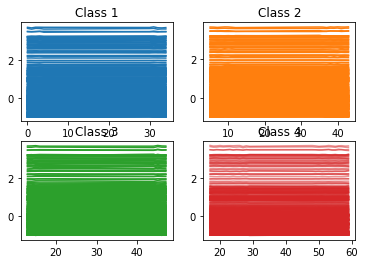

In [5]:
# Plotting feature curves like example
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(data[data[570]==1].iloc[:,:-1], 'tab:blue')
axs[0, 0].set_title('Class 1')
axs[0, 1].plot(data[data[570]==2].iloc[:,:-1], 'tab:orange')
axs[0, 1].set_title('Class 2')
axs[1, 0].plot(data[data[570]==3].iloc[:,:-1], 'tab:green')
axs[1, 0].set_title('Class 3')
axs[1, 1].plot(data[data[570]==4].iloc[:,:-1], 'tab:red', alpha=0.5)
axs[1, 1].set_title('Class 4')


## Part 1
Use cubic B-splines with 70 knots for dimension reduction and feature extraction. Use the extracted features (B-spline coefficients) to build a multi-class support vector machine (SVM). Evaluate the performance of your classifier on the test set. Report the accuracy and confusion matrix.

In [6]:
# STEP 1: Extract features from data using BSpline
x = np.linspace(0, 1, 570)
# x = np.array(X.mean(axis = 0))
# x.sort()
knots = np.linspace(x[0], x[-1], 70)
B = BSplineBasis(x, knots, degree=3)[:,:-2]

# Least Square Estimation
# x_proj_matrix = B@np.linalg.inv(B.T@B)@B.T
Bcoef = np.linalg.lstsq(B, X.T, rcond=-1)[0].T

# STEP 2: Train a classifier using extracted features
svm = SVC()
svm.fit(Bcoef[0:30, :], y_train)
pred = svm.predict(Bcoef[30:60, :])
conf = confusion_matrix(y_test, pred)
conf = pd.DataFrame(conf, index=['Class 1', 'Class 2', 'Class 3', 'Class 4'], columns=[
                    'Pred 1', 'Pred 2', 'Pred 3', 'Pred 4'])
svm_acc = accuracy_score(y_test, pred)

print("----- Results for BSpline + SVM -----")
print(conf)
print("Accuracy Score: " + str(round(svm_acc,2)))

----- Results for BSpline + SVM -----
         Pred 1  Pred 2  Pred 3  Pred 4
Class 1       0       0       0       5
Class 2       0       0       0       9
Class 3       0       0       0       4
Class 4       0       0       0      12
Accuracy Score: 0.4


## Part 2
Use functional PCA for dimension reduction and feature extraction. Build four multi-class SVMs using 2, 5, 8, and 10 harmonics. Evaluate the performance of your classifiers on the test set. Report the accuracy and confusion matrix of the four classifiers.

In [7]:
# STEP 1: Extract features from data using functional PCA
B_stacked = np.tile(B.T, 60).T
X_stacked = np.array(X).ravel()
beta = np.linalg.lstsq(B_stacked, X_stacked)[0]
mu_hat = B.dot(beta)  # Mean function via B-Spline
diffs = X-mu_hat
Cov = np.cov(diffs.T)
Cov = gaussian_filter(Cov, sigma=7)
l, psi = np.linalg.eigh(Cov)

/var/folders/2z/f9j24r0933xgycd9ssp8d6rc0000gn/T/ipykernel_34370/3800509268.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta = np.linalg.lstsq(B_stacked, X_stacked)[0]


In [8]:
# STEP 2: Train a classifier using extracted features
for i in [2,5,8,10]:
    PCs = psi[:, -i:]
    FPC_scores = diffs.dot(PCs)
    svm_pca = SVC()
    svm_pca.fit(FPC_scores[0:30], y_train)
    pca_pred = svm_pca.predict(FPC_scores[30:60])
    pca_conf = confusion_matrix(y_test, pca_pred)
    pca_conf = pd.DataFrame(conf, index=['Class 1', 'Class 2', 'Class 3', 'Class 4'], columns=[
                        'Pred 1', 'Pred 2', 'Pred 3', 'Pred 4'])
    svm_pca_acc = accuracy_score(y_test, pca_pred)

    print("----- Results for " + str(i) + " PC + SVM -----")
    print(pca_conf)
    print("Accuracy Score: " + str(round(svm_pca_acc,2)))
    print("")

----- Results for 2 PC + SVM -----
         Pred 1  Pred 2  Pred 3  Pred 4
Class 1       0       0       0       5
Class 2       0       0       0       9
Class 3       0       0       0       4
Class 4       0       0       0      12
Accuracy Score: 0.83

----- Results for 5 PC + SVM -----
         Pred 1  Pred 2  Pred 3  Pred 4
Class 1       0       0       0       5
Class 2       0       0       0       9
Class 3       0       0       0       4
Class 4       0       0       0      12
Accuracy Score: 0.87

----- Results for 8 PC + SVM -----
         Pred 1  Pred 2  Pred 3  Pred 4
Class 1       0       0       0       5
Class 2       0       0       0       9
Class 3       0       0       0       4
Class 4       0       0       0      12
Accuracy Score: 0.87

----- Results for 10 PC + SVM -----
         Pred 1  Pred 2  Pred 3  Pred 4
Class 1       0       0       0       5
Class 2       0       0       0       9
Class 3       0       0       0       4
Class 4       0       0       0  